In [1]:
import sys
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from datetime import datetime
from itertools import combinations

PREDICCION_REAL = False
MAXIMIZAR_HIPERPARAMETROS = False
PARAMETROS = {"booster":"gbtree", "max_depth":4, "eta": 0.4, "objective": "binary:logistic", "nthread":2,"gamma" : 0}
RONDAS = 30

In [2]:
#APERTURA DE ARCHIVO DE ARCHIVOS
entrenamiento_temp = pd.read_csv("../Train_TP2_Datos_2020-2C.csv")
entrenamiento_temp = entrenamiento_temp[( entrenamiento_temp['Stage'] == 'Closed Won') | ( entrenamiento_temp['Stage'] == 'Closed Lost')]
entrenamiento_temp = entrenamiento_temp.loc[(entrenamiento_temp["ASP_Currency"] == entrenamiento_temp["Total_Taxable_Amount_Currency"])]
#entrenamiento = entrenamiento.loc[entrenamiento["Total_Taxable_Amount"] > 0]

test = pd.read_csv("../Test_TP2_Datos_2020-2C.csv")

In [3]:
#FORMATO FECHAS

#Respalda fecha, usada para separa entrenamiento y test
entrenamiento_temp['Fecha'] = pd.to_datetime(entrenamiento_temp['Opportunity_Created_Date'])
columnas_fecha = ['Month','Last_Modified_Date','Account_Created_Date','Opportunity_Created_Date','Quote_Expiry_Date','Planned_Delivery_Start_Date','Planned_Delivery_End_Date']

def formato_fechas(x):
    for columna in columnas_fecha:
        x[columna] = pd.to_datetime(x[columna])
        
formato_fechas(entrenamiento_temp)
if(PREDICCION_REAL): 
    formato_fechas(test)

In [4]:
#DIVISION ENTRE SET DE ENTRENAMIENTO Y SET DE TEST

if(PREDICCION_REAL):
    entrenamiento = entrenamiento_temp
else:
    entrenamiento = entrenamiento_temp.loc[entrenamiento_temp['Fecha'].dt.year == 2015].copy()
    test          = entrenamiento_temp.loc[entrenamiento_temp['Fecha'].dt.year == 2016].copy()
    entrenamiento_label = (entrenamiento['Stage'] == 'Closed Won').astype(int)
    test_label          = (test['Stage'] == 'Closed Won').astype(int)

del entrenamiento_temp


In [5]:
#LIMPIEZA

def limpiar(x):
    x = x.drop(columns=['ASP_(converted)_Currency','Quote_Type','Brand','Product_Type','Size','Product_Category_B','Price','Currency','Last_Activity','Actual_Delivery_Date','Prod_Category_A'])
    x = x.drop(columns=['Opportunity_Name','Sales_Contract_No'])
    return x

entrenamiento = limpiar(entrenamiento)
test = limpiar(test)

In [ ]:
#NUEVOS FEATURES

In [6]:
#Agrego feature: Duracion de la oportunidad
entrenamiento['Opportunity_Duration'] = (entrenamiento['Last_Modified_Date'] - entrenamiento['Opportunity_Created_Date']) / np.timedelta64(1, 'D')
test['Opportunity_Duration'] = (test['Last_Modified_Date'] - test['Opportunity_Created_Date']) / np.timedelta64(1, 'D')
#Agrego feature: Total_Amount_USD
entrenamiento["Total_Amount_USD"] = entrenamiento["Total_Amount"] * entrenamiento["ASP_(converted)"] / entrenamiento["ASP"]
test["Total_Amount_USD"] = test["Total_Amount"] * test["ASP_(converted)"] / test["ASP"]
#Agrego feature: Total_Taxable_Amount_USD
entrenamiento["Total_Taxable_Amount_USD"] = entrenamiento["Total_Taxable_Amount"] * entrenamiento["ASP_(converted)"] / entrenamiento["ASP"]
test["Total_Taxable_Amount_USD"] = test["Total_Taxable_Amount"] * test["ASP_(converted)"] / test["ASP"]
#Agrego feature: Total_Amount_sobre_Total_Taxable_Amount
entrenamiento["Total_Amount_sobre_Total_Taxable_Amount"] = entrenamiento["Total_Amount_USD"] / entrenamiento["Total_Taxable_Amount_USD"]
test["Total_Amount_sobre_Total_Taxable_Amount"] = test["Total_Amount_USD"] / test["Total_Taxable_Amount_USD"]

"""
#Se debe solo usar los del train, no los del test, CAMBIAR
entrenamiento["Billing_Country_Vida_Util"] = entrenamiento.groupby("Billing_Country")["Opportunity_Duration"].transform("mean")
entrenamiento["Account_Type_Vida_Util"] = entrenamiento.groupby("Account_Type")["Opportunity_Duration"].transform("mean")
entrenamiento["Region_ASP"] = entrenamiento.groupby("Region")["ASP"].transform("mean")
entrenamiento["Billing_Country_ASP"] = entrenamiento.groupby("Billing_Country")["ASP"].transform("mean")
entrenamiento["Billing_Country_Total_Amount"] = entrenamiento.groupby("Billing_Country")["Total_Amount_USD"].transform("mean")
entrenamiento["Billing_Country_Buro"] = entrenamiento.groupby("Billing_Country")["Bureaucratic_Code_0_Approved"].transform("mean")
entrenamiento["Product_Family_Vida_Util"] = entrenamiento.groupby("Product_Family")["Opportunity_Duration"].transform("mean")
entrenamiento["Product_Family_Total_Amount"] = entrenamiento.groupby("Product_Family")["Total_Amount"].transform("mean")
entrenamiento["Product_Family_Buro"] = entrenamiento.groupby("Product_Family")["Bureaucratic_Code_0_Approved"].transform("mean")
"""

'\n#Se debe solo usar los del train, no los del test, CAMBIAR\nentrenamiento["Billing_Country_Vida_Util"] = entrenamiento.groupby("Billing_Country")["Opportunity_Duration"].transform("mean")\nentrenamiento["Account_Type_Vida_Util"] = entrenamiento.groupby("Account_Type")["Opportunity_Duration"].transform("mean")\nentrenamiento["Region_ASP"] = entrenamiento.groupby("Region")["ASP"].transform("mean")\nentrenamiento["Billing_Country_ASP"] = entrenamiento.groupby("Billing_Country")["ASP"].transform("mean")\nentrenamiento["Billing_Country_Total_Amount"] = entrenamiento.groupby("Billing_Country")["Total_Amount_USD"].transform("mean")\nentrenamiento["Billing_Country_Buro"] = entrenamiento.groupby("Billing_Country")["Bureaucratic_Code_0_Approved"].transform("mean")\nentrenamiento["Product_Family_Vida_Util"] = entrenamiento.groupby("Product_Family")["Opportunity_Duration"].transform("mean")\nentrenamiento["Product_Family_Total_Amount"] = entrenamiento.groupby("Product_Family")["Total_Amount"].t

In [7]:

#Agrego feature: Duracion por region
duracion_region = pd.read_csv('duracion_region.csv')
entrenamiento = entrenamiento.merge(duracion_region,on='Region',how='left')
test = test.merge(duracion_region,on='Region',how='left')

#Agrego feature: Duracion por territorio
duracion_territorio = pd.read_csv('duracion_territorio.csv')
entrenamiento = entrenamiento.merge(duracion_territorio,on='Territory',how='left')
test = test.merge(duracion_territorio,on='Territory',how='left')

#Agrego feature: Comportamiento segun territorio
comportamiento_territorio =  pd.read_csv('comportamiento_territorio.csv')
entrenamiento = entrenamiento.merge(comportamiento_territorio,on='Territory',how='left')
test = test.merge(comportamiento_territorio,on='Territory',how='left')

In [8]:
#FECHAS A DIAS
def fecha_a_dias(x):
    for columna in columnas_fecha:
        x[columna] = x[columna].apply(lambda x : (x - pd.to_datetime('01/01/2000', format='%m/%d/%Y')).days)

fecha_a_dias(entrenamiento)
fecha_a_dias(test)

In [9]:
#CATEGORICAS A NUMERICAS - PROMEDIO
"""Se debe pasar train y test ordenados """
def expansion_mean_encoding(columnas_categoricas,train,test,label):
    #Dividimos el dataset de entrenamiento en features y labels
    #Armo un df extra que me ayudara para codificar las categoricas.
    #x_y_train = filtrado.iloc[:-test_rows]
    #x_train = x_y_train.drop('Stage', axis=1)
    #y_train = x_y_train['Stage'].to_frame()
    #x_test = filtrado.iloc[-test_rows:].drop('Stage', axis=1)
    #y_test = filtrado.iloc[-test_rows:]['Stage'].to_frame()

    #En el set de train.
    #columnas_categoricas = x_train.select_dtypes(include='category').columns

    codificaciones = dict()

    for col in columnas_categoricas:
        last_one = train.groupby(col).tail(1)
        for (idx, reg) in zip(last_one[col].index, last_one[col].values):
            codificaciones[reg] = (col, idx)
        cumulative_sum = train.groupby(col)[label].cumsum() - train[label]
        cumulative_count = train.groupby(col).cumcount()
        train[col] = cumulative_sum/cumulative_count

    #Llenamos los NaN generados por cumsum con ceros.
    train.fillna(0,inplace = True)

    #Guardamos la codificacion de cada categoria segun su nombre.
    for k, v in codificaciones.items():
        col = v[0]
        idx = v[1]
        codificaciones[k] = train.loc[idx, col]
    
    # Utilizo las ultimas codificaciones de cada categoria del train set para codificar el test set.
    # Para eso utilizo el diccionario de codificaciones.

    #columnas_categoricas = x_test.select_dtypes(include='category').columns

    for col in columnas_categoricas:
        test[col] = test[col].astype(object)
        for (idx, reg) in zip(test[col].index, test[col]):
            if (reg in codificaciones):
                test.loc[idx, col] = codificaciones[reg]
            else:
                #Codifico como cero, se puede mejorar
                test.loc[idx, col] = 0
        test[col] = test[col].astype(float)
        
columnas_categoricas = list(entrenamiento.select_dtypes(include=['object']).columns)
if 'Stage' in columnas_categoricas : columnas_categoricas.remove('Stage')
entrenamiento["label"] = (entrenamiento['Stage'] == 'Closed Won').astype(int)
entrenamiento.sort_values("Fecha")
expansion_mean_encoding(columnas_categoricas,entrenamiento,test,"label")
entrenamiento = entrenamiento.drop(columns='label')

In [10]:
#CATEGORICAS A NUMERICAS  - ORDINAL
def categoricas_a_numericas(x):
    ohe = skl.preprocessing.OrdinalEncoder()
    columnas_object = list(x.select_dtypes(include=['object']).columns)
    if 'Stage' in columnas_object : columnas_object.remove('Stage')
    for columna in columnas_object:
        copia = x[[columna]].copy().dropna()
        df_temp = pd.DataFrame(ohe.fit_transform(copia)).astype('int32')
        df_temp.columns = [columna]
        x[columna] = df_temp[columna]

categoricas_a_numericas(entrenamiento)
categoricas_a_numericas(test)

In [11]:
#Filtrado de columnas - No remover Stage o Fecha
#entrenamiento = entrenamiento[['Total_Amount_Currency']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, 0 to 1006
Data columns (total 57 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   ID                                       1007 non-null   int64         
 1   Region                                   1007 non-null   float64       
 2   Territory                                1007 non-null   float64       
 3   Pricing, Delivery_Terms_Quote_Appr       1007 non-null   int64         
 4   Pricing, Delivery_Terms_Approved         1007 non-null   int64         
 5   Bureaucratic_Code_0_Approval             1007 non-null   int64         
 6   Bureaucratic_Code_0_Approved             1007 non-null   int64         
 7   Submitted_for_Approval                   1007 non-null   int64         
 8   Bureaucratic_Code                        1007 non-null   float64       
 9   Account_Created_Date                     

In [12]:
if(PREDICCION_REAL):
    objetivo = (entrenamiento['Stage'] == 'Closed Won').astype(int)
    entrenamiento = entrenamiento.drop(columns=['Stage','Fecha'])
    
    d_entrenamiento = xgb.DMatrix(entrenamiento.values, objetivo.values)
    d_prueba = xgb.DMatrix(test.values)
    
    bst = xgb.train(PARAMETROS, d_entrenamiento, RONDAS)
    preds = bst.predict(d_prueba)

    resultados = test[['Opportunity_ID']].copy()
    resultados['Target'] = pd.Series(preds)
    resultados = resultados.groupby('Opportunity_ID').mean()
    resultados = resultados.reset_index()
    resultados['Target'] = resultados['Target'].apply(lambda x: int(x >= 0.5))
    
    resultados.to_csv("prediccion.csv", index=False)
    resultados['Target'].value_counts()

In [13]:
if(PREDICCION_REAL): sys.exit()

In [14]:
set_entrenamiento = xgb.DMatrix(entrenamiento.drop(columns=['Stage','Fecha']),label = entrenamiento_label)
set_test  = xgb.DMatrix(test .drop(columns=['Stage','Fecha']),label = test_label)
evaluacion = [(set_test, 'eval'), (set_entrenamiento, 'train')]

[22:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.72139	train-logloss:0.43041
[1]	eval-logloss:0.77251	train-logloss:0.30644
[2]	eval-logloss:0.84268	train-logloss:0.23378
[3]	eval-logloss:0.88222	train-logloss:0.18577
[4]	eval-logloss:0.79747	train-logloss:0.15529
[5]	eval-logloss:0.73104	train-logloss:0.12680
[6]	eval-logloss:0.68110	train-logloss:0.10931
[7]	eval-logloss:0.62037	train-logloss:0.09149
[8]	eval-logloss:0.58861	train-logloss:0.08030
[9]	eval-logloss:0.56025	train-logloss:0.07333
[10]	eval-logloss:0.53782	train-logloss:0.06295
[11]	eval-logloss:0.51771	train-logloss:0.05650
[12]	eval-logloss:0.50119	train-logloss:0.05254
[13]	eval-logloss:0.47173	train-logloss:0.04590
[14]	eval-logloss:0.46295	tr

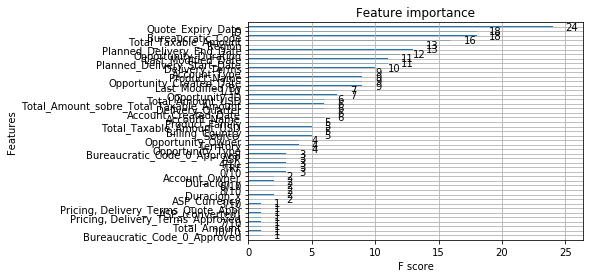

In [15]:
modelo = xgb.train(PARAMETROS, set_entrenamiento, RONDAS, evaluacion)

xgb.plot_importance(modelo)
plt.show()

In [16]:
prediccion = modelo.predict(set_test)

prediccion = [1 if i > .5 else 0 for i in prediccion]

def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metrics = metricas(test_label, prediccion)
print("Prediccion Test")
[print(i) for i in metrics]
print(skl.metrics.log_loss(test_label,prediccion))

prediccion = modelo.predict(set_entrenamiento)
prediccion = [1 if i > .5 else 0 for i in prediccion]
metricas = metricas(entrenamiento_label, prediccion)
print("Prediccion Train")
[print(i) for i in metricas]

Prediccion Test
[[1715  536]
 [ 431 1664]]
0.7774965485503912
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2251
           1       0.76      0.79      0.77      2095

    accuracy                           0.78      4346
   macro avg       0.78      0.78      0.78      4346
weighted avg       0.78      0.78      0.78      4346

7.685095572503731
Prediccion Train
[[732   0]
 [  0 275]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       1.00      1.00      1.00       275

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00      1.00      1007



[None, None, None]

In [17]:
if(not MAXIMIZAR_HIPERPARAMETROS): sys.exit()
    
min_log_loss = 1000
d = 1000
e = 1000
r = 1000
for depth in range(2,14):
    for eta in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        for rondas in [10,20,30,40]:
            parametros = {"booster":"gbtree", "max_depth":depth, "eta": eta, "objective": "binary:logistic", "nthread":2}
            modelo = xgb.train(parametros, set_entrenamiento, rondas, evaluacion)
            prediccion = modelo.predict(set_test)
            prediccion = [1 if i > .5 else 0 for i in prediccion]
            log_loss = skl.metrics.log_loss(test_label,prediccion)
            if (log_loss < min_log_loss):
                min_log_loss = log_loss
                d = depth
                e = eta
                r = rondas


print("log: ",min_log_loss)                
print("depth: ",d)      
print("eta: ",e)      
print("rondas: ",r)

SystemExit: 

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
